# Getting Organized

In [26]:
import numpy as np
np.random.seed(42)
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# Pandas
import pandas as pd

# RYO
from app.ts_decomposition.data.energy_connection import EnergyConnection
from app.ts_decomposition.model.series_sample import TimeSeriesSample



# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [27]:
# Config
PROJECT_ROOT_DIR = "."
PROJECT_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')


# Save Images
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

# File
FILE_NAME = "energydata_complete.csv"

In [28]:
# Util Funcs
def load_data(file_name, data_path="."):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Load Data from Influx
*If there are no room readings, it is because I have not worked through that part of the TimeSeriesSample lib

In [29]:
energy_connection = EnergyConnection()

# Generate frames from connections
sample_frame = energy_connection.sample_series('energy_readings')

# TODO: Rooms/QL Extract

sample_frame = energy_connection.sample_series('external_readings', append_frame=sample_frame)

# Add to object
sample = TimeSeriesSample(sample_frame, 'time')

In [ ]:
#TODO: Broken bc time is now the actual index, need to modify w/o 'key' 
# Decomp
sample.day_of_week_class()
sample.weekend_weekday_class()

sample.clean_lights()

sample.base.describe()

In [30]:
sample.split_ts(20)

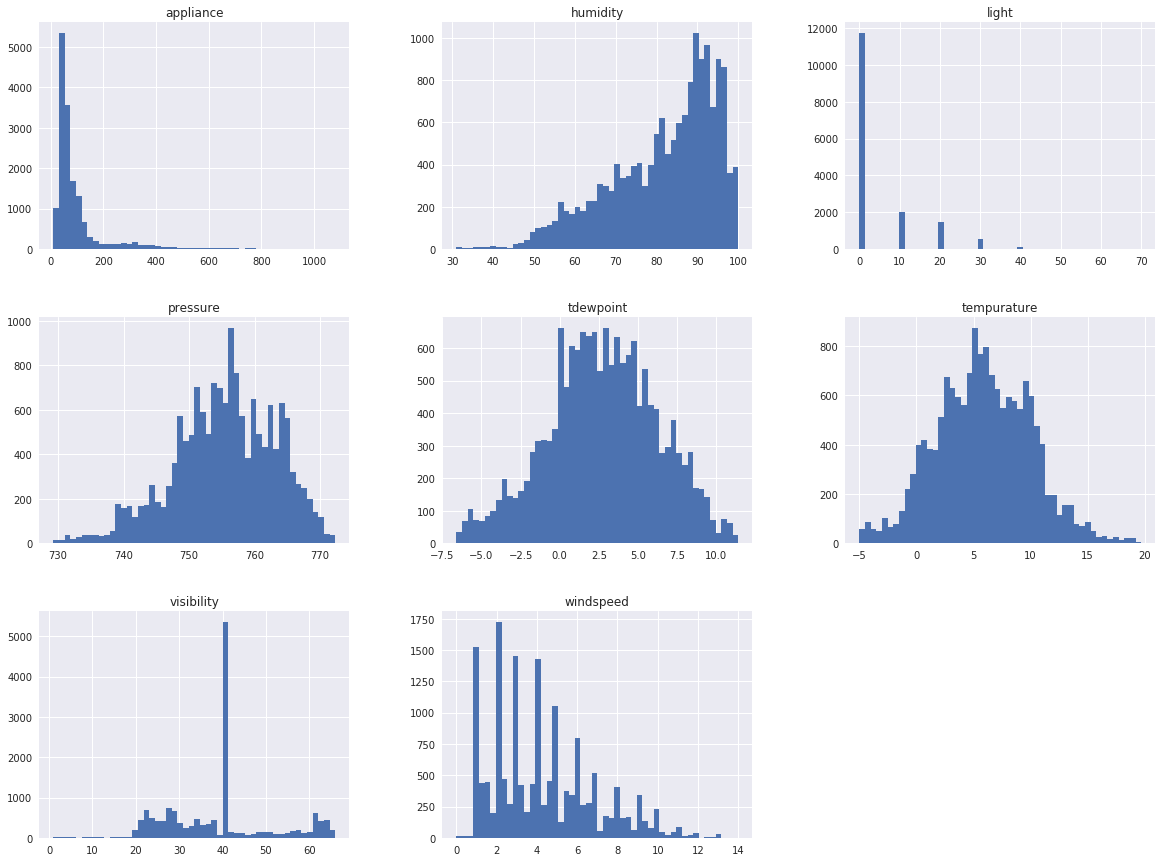

In [31]:
%matplotlib inline



import matplotlib.pyplot as plt
sample.base.hist(bins=50, figsize=(20,15))
plt.show()

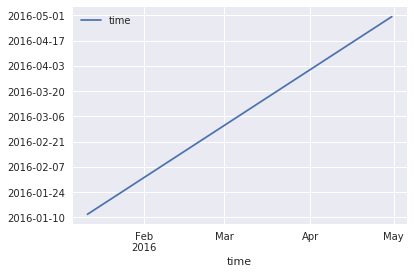

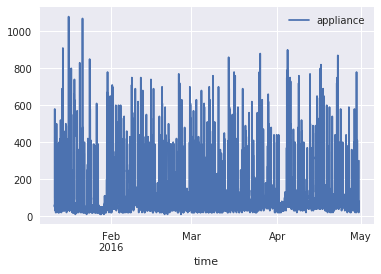

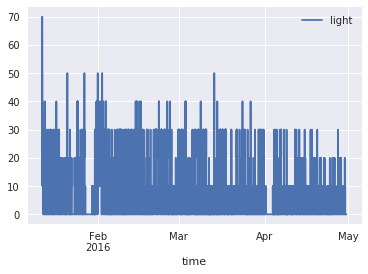

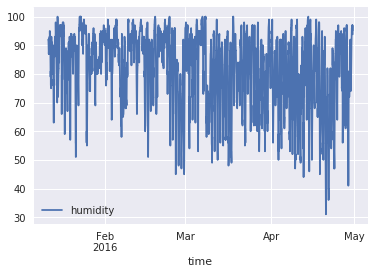

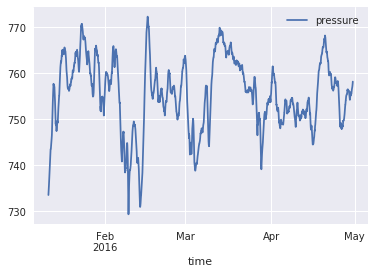

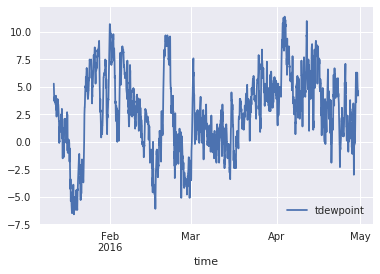

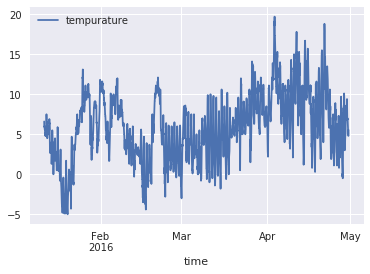

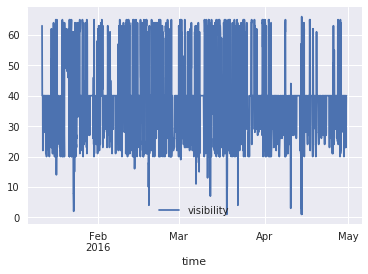

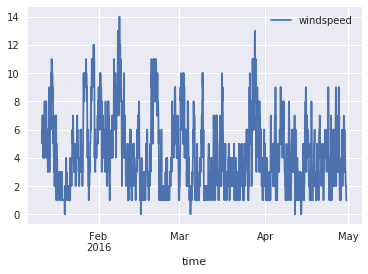

In [32]:
%matplotlib inline
ignore = ['sourceid_x', 'sourceid_y']

cat = [
    'light',
    'light_cleaned',
    'light_on',
    'visibility',
    'day_of_week_class',
    'weekend_weekday_class'
]

sample.categorical_features = cat

for series in sample.base:

    if series not in ignore:
        #print(series)
        sample.base.plot(kind='line', x=sample.base.index, y=series)

plt.show()

# Now we can observe (read: clean)

### Analog Signal ?
Appliances: Standard Dev is high compared to mean, especially factoring in min and max. So, we will have a big initial hump (maybe close to localized normal), and some BIG positive outliers

Lights: 
    - a lot of time on 0, maybe we can catogorize/bin this val
    - Super stochastic?
    - fuzzy => off, low, mid, hi?
    
### Digital Signal?
Visibility: 
    - one huge bin?
    - Split into two "non 40" vars, take the hist there?
    - Check: three fuzzy blocks?
    
Windspeed: Levels?

Temps:
    - "Spikey bins"? => Equilibrium point/level?
    - otherwise center lump
    
Humidity:
    - left side lump
    - but one is flat?
    - definitely some cutoff
    

# TODO: 
Switch to TS Object from lib
Make the influx cutoff from there

Two sided structure: 
    - dataframe for Jupyter Analytics
    - Array for implimented ML algorithms
    

# Go through the series 

In [33]:
# Stationality 
from statsmodels.tsa.stattools import adfuller

# Autocorr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decomps
from statsmodels.tsa.seasonal import seasonal_decompose

from stldecompose import decompose

# ARIMA
from statsmodels.tsa.arima_model import ARIMA
# Resid
from numpy import histogram

# Jupyter
from matplotlib import pyplot



from pandas import Series
from matplotlib import pyplot
from numpy import log

# Appliance Energy


/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


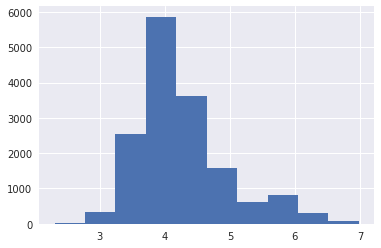

In [34]:
series='appliance'
series_log = series + '_log'

X = sample.base[series].values
#series_log = Series(log(X))
sample.base[series_log] = log(X)

#sample.base[series_log].plot()
sample.base[series_log].hist()

plt.show()

Log gets you something a little more gaussian, I think energy is looking more like a Poisson. The series ploy 

### Stationality
https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html

In [ ]:
result = adfuller(sample.base[series].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

H(0): Has unit root, is non stationary

H(1): No unit root, is stationary

p = 0 => Reject (p<0.05)

ADF is low, so stationary

This would indicate that the series is stationary

but really small p may want tot

### Auto Corr/Cov
https://people.maths.bris.ac.uk/~magpn/Research/LSTS/LACF.html

In [ ]:
plot_acf(sample.base[series], lags=500)
pyplot.show()

In [ ]:
plot_pacf(sample.base[series], lags=500)
pyplot.show()

Looks like some autocorrelation past 1, up to an oscilation. Is that oscilation something to look into?

### Seasonal Decompose

In [ ]:
%matplotlib inline

#model = 'additive'
model = 'multiplicitive'

freq = 144
#freq = 1008

#result = seasonal_decompose(sample.base[series_log].values, model=model, freq=freq)
result = seasonal_decompose(sample.base[series].values, model=model, freq=freq)

# Out
result.plot()
pyplot.show()

In [ ]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [ ]:
residuals = result.resid[freq:len(result.resid)-freq]
#hist = histogram(residuals)
plt.hist(residuals)

### STL Decompose

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base[series_log].values, period=freq)

# Out
result.plot()
pyplot.show()

In [ ]:
residuals = result.resid[freq:len(result.resid)-freq]
#hist = histogram(residuals)
plt.hist(residuals)

Trend:
    - range of trend scales roughly inverse to freq
    - same for mult v add (because same rolling mean method)
    - even at the day level, range is ~20% of observed. So small scale trend
    - makes a case for stationary as well?
Seasonal:
    - looks roughly the same shape on multiplicative 
    - just scaled up
    - hard to check for consistency at day level, but month seems ok
Residual:
    - either a high season, low residual, or low season high residual
    - looks different shape though? Not sure what this is.

In [ ]:
# How to calculate R2 w/ moving trend? Or is yhat just the mean, not trend? Should it be of detrend?
# R_SQR should be high or low, based on https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html?
result = seasonal_decompose(sample.base[series].values, model=model, two_sided=two_side, freq=period)
print(result.resid[period:len(result.resid)-period])

ss_res = [(res*res for res in result.resid[period:])]



In [ ]:
#sample.base['time']
sample.base.index

### AR (I) MA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
 
arima_order = (5,1,0)

# fit model
X = sample.base[series]

X = X.astype('float64')

arima = ARIMA(X, order=arima_order)
#arima = ARIMA(sample.base[series], order=arima_order)
arima_fit = arima.fit(isp=0)
print(arima_fit.summary())

# plot residual errors
residuals = DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [ ]:
%matplotlib inline

result = seasonal_decompose(sample.base[series].values, model='multiplicitive', freq=144)

# Out
result.plot()
pyplot.show()

In [ ]:
residuals = result.resid[period:len(result.resid)-period]
plt.hist(residuals)
pyplot.show()

In [ ]:
%matplotlib inline

result = seasonal_decompose(sample.base[series].values, model='additive', freq=1008)

# Out
result.plot()
pyplot.show()

In [ ]:
residuals = result.resid[period:len(result.resid)-period]
residuals
#plt.hist(residuals)
#pyplot.show()

In [ ]:
%matplotlib inline

result = seasonal_decompose(sample.base[series].values, model='multiplicitive', freq=1008)

# Out
result.plot()
pyplot.show()

In [ ]:
residuals = result.resid[period:len(result.resid)-period]
plt.hist(residuals)
pyplot.show()

# Light Energy

### Seasonal Decompose

In [ ]:
series='light'

In [ ]:
%matplotlib inline

result = seasonal_decompose(sample.base[series].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

### STL Decompose

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base[series].values, period=period)

# Out
result.plot()
pyplot.show()

# Humidity

### Seasonal Decompose

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['humidity'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

In [ ]:
print(result)

### STL Decompose

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['humidity'].values, period=period)

# Out
result.plot()
pyplot.show()

# Decomp

## Stationality

## DF Test
https://machinelearningmastery.com/time-series-data-stationary-python/

# Decomp

# Seasonal Decompose

# Temp

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['tempurature'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

# Dewpoint

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['tdewpoint'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

# Pressure

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['pressure'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

# Temp

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['tempurature'].values, period=period)

# Out
result.plot()
pyplot.show()

# Dewpoint

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['tdewpoint'].values, period=period)

# Out
result.plot()
pyplot.show()

# Pressure

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['pressure'].values, period=period)

# Out
result.plot()
pyplot.show()

### Observations

I think most of these trend lines would indicate stationality, i.e. small variations relative to the range.

So, it looks like some genral time series approaches may hit some snags. May have to dip into some signal processing to smooth, maybe initially? These "business level" "time series" may be more meaningful over longer periods, or even just after some noise reduction or smoothing techniques are applie. 

# Signal Processing

So, it looks like some genral time series approaches may hit some snags. May have to dip into some signal processing to smooth, maybe initially? These "business level" "time series" may be more meaningful over longer periods, or even just after some noise reduction or smoothing techniques are applie. 